# Exercise 2

## Fundamentals of Machine Learning

#### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl

#### Version information:
        2020-12-07: v.1.0. First public release. 


In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn import model_selection

from scipy.stats import multivariate_normal

## 3 - Data Preparation
We filter the full digits dataset such that only the digits "1" and "7" are left. Of the remaining 361 instances, we split these up into a training and test set with proportions 3 to 2 respectively.

In [2]:
# Import the digits dataset
digits = load_digits()

print(digits.keys())

data         = digits["data"]
images       = digits["images"]
target       = digits["target"]
target_names = digits["target_names"]

# Filter out ones and sevens from the dataset.
mask = (target == 1) | (target == 7)
data_filtered   = data[mask]
target_filtered = target[mask]

# Create training and test sets, only containing ones and sevens.
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_filtered,target_filtered,test_size=0.4,random_state=0)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [3]:
X_train.shape[0]/X_test.shape[0]

1.4896551724137932

### 3.1 - Dimension reduction (3 pts)
We use a simple minded approach of looking at the average images of each class and finding suitable pixels that have the largest differences in the average pixel values. These pixels should theoretically best characterise and differentiate each class from one another.

[10 19 20 27 29 37 52 53 60 61]


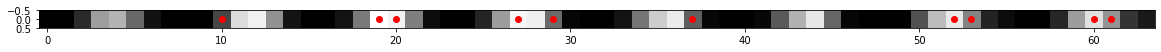

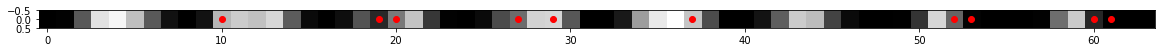

In [4]:
mask_ones     = (target == 1) 
mask_sevens   = (target == 7)
data_ones   = data[mask_ones,:]
data_sevens = data[mask_sevens,:]

# Average flatten images for each digit.
data_avg_one   = np.average(data_ones, axis=0)
data_avg_seven = np.average(data_sevens, axis=0)

# Top 10 pixels with largest difference in average values between the two classes. 
pixel_candidates =  np.argsort(-np.abs(data_avg_one-data_avg_seven))[0:10]
print(np.sort(pixel_candidates))

# Plot "flat" average images.
plt.figure(figsize=(20,10))
plt.gray()
plt.imshow(data_avg_one[None,:], interpolation="nearest")
plt.scatter(pixel_candidates, np.zeros_like(pixel_candidates), color='red')
plt.show()

plt.figure(figsize=(20,10))
plt.gray()
plt.imshow(data_avg_seven[None,:], interpolation="nearest")
plt.scatter(pixel_candidates, np.zeros_like(pixel_candidates), color='red')
plt.show()

So, the pixels with the flattened indices printed above are the 10 pixels with the largest differences between the two class averages. We can convert the linear indicies to 2D indicies to visualize their positions in the average images of either class. 

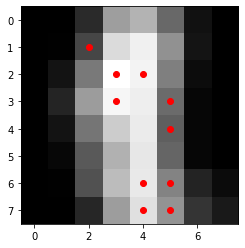

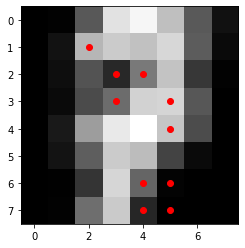

In [5]:
images_ones   = images[mask_ones,:,:]
images_sevens = images[mask_sevens,:,:]

img_avg_one   = np.average(images_ones, axis=0)
img_avg_seven = np.average(images_sevens, axis=0)

x = pixel_candidates % 8
y = pixel_candidates // 8

plt.figure()
plt.gray()
plt.imshow(img_avg_one, interpolation="nearest")
plt.scatter(x,y, color='red')
plt.show()

plt.figure()
plt.gray()
plt.imshow(img_avg_seven, interpolation="nearest")
plt.scatter(x,y, color='red')
plt.show()

Thus, we implement an function to reduce the number of dimensions from 64 to 2. We simply do so by calculating averages over two different sets of the 10 red-marked pixel positions above.

Reduced feature 1: Average of pixel values in the 5 top-most positions marked above. In other words, average over positions 10, 19, 20, 27 and 29.

Reduced feature 2: Average of pixel values in the 5 bottom-most positions marked above. In other words, average over positions 37, 52, 53, 60 and 61.

In [6]:
def reduce_dim(x):
    pixels = np.sort(pixel_candidates)
    a = np.mean(x[:,pixels[0:5]],axis=1)
    b = np.mean(x[:,pixels[5:]],axis=1)
    return np.stack([a,b], axis=-1)

### 3.2 - Scatterplot (4 pts)

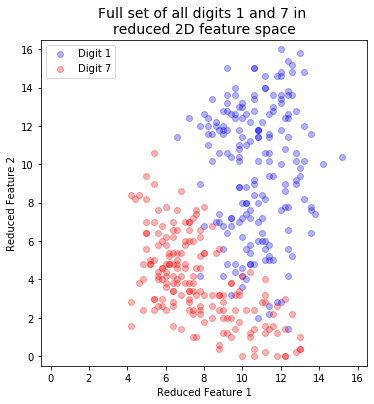

In [7]:
reduced_ones   = reduce_dim(data_ones)
reduced_sevens = reduce_dim(data_sevens)

plt.figure(figsize=(6,6))
plt.scatter(reduced_ones[:,0], reduced_ones[:,1], c="b", alpha=0.3, label='Digit 1')
plt.scatter(reduced_sevens[:,0], reduced_sevens[:,1], c="r", alpha=0.3,label='Digit 7')
plt.axes().set_aspect('equal')
plt.axes().set_xlim(-.5,16.5)
plt.axes().set_ylim(-.5,16.5)
plt.xlabel('Reduced Feature 1')
plt.ylabel('Reduced Feature 2')
plt.title('Full set of all digits 1 and 7 in \nreduced 2D feature space', fontsize=14)
plt.legend()
plt.savefig('alldigits_1_7_reduced.pdf')

## 4 - Nearest Mean
### 4.1 - Implement the Nearest Mean Classifier (3 pts)
Find the mean of the 2D feature vectors of each class in the training set and assign the label of its nearest mean to test each test instance.

In [8]:
def nearest_mean(training_features, training_labels, test_features):
    """
    Implementation of the nearest mean classifier. The training features used as input 
    must be outputs from the reduce_dim() function.
    
    params
    ------
    training_features: np.array
        Matrix of shape (N,2), where N is the number of training instances.
    training_labels: np.array
        Matrix of shape (N,), where N is the number of training instances.
    test_features: np.array
        Matrix of shape (M,2), where M is the number of test instances. 

    returns
    -------
    np.array shape=(M,)
        Predicted labels for the test features, given the training set.
    """
    # Find all classes in the training set.
    unique_labels = np.unique(training_labels)

    # Calculate the 2D mean in feature space for each class independently.
    mu = np.zeros((unique_labels.shape[0], 2))
    for idx, label in enumerate(unique_labels):
        mu[idx] = np.average(training_features[training_labels == label], axis=0)

    # For each test instance, find the distances to all class means.
    dist = np.linalg.norm(test_features[:,None]-mu, axis=2)

    # Find the label of the closest class mean for each test instance.
    predicted_labels = unique_labels[np.argmin(dist, axis=1)]

    return predicted_labels, mu

### 4.2 - Visualize the decision regions (4 pts)

In [9]:
# Create the reduced test and training sets.
X_train_red = reduce_dim(X_train)
X_test_red  = reduce_dim(X_test)

# Prectict labels using the Nearest Mean Method.
predicted_labels, mu = nearest_mean(X_train_red, y_train, X_test_red)

# (Not needed) Calculate error rate of the predictions.
error_rate = np.sum(predicted_labels != y_test)/y_test.shape[0]
print(f'Error rate of Nearest Mean classification: {error_rate}')

Error rate of Nearest Mean classification: 0.13793103448275862


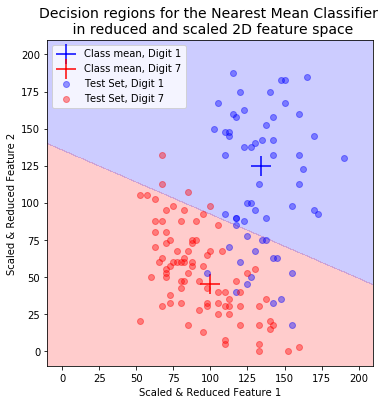

In [10]:
# Function to transform points in 2d feature space [0,16]^2 to a 200x200 gridspace.
def transform(X_reduced):
    return 12.5*X_reduced

# Transform test and train data to grid space.
X_train_scaled  = transform(X_train_red)
X_test_scaled   = transform(X_test_red)
mu_scaled       = transform(mu)

# Create figure.
plt.figure(figsize=(6,6))

# Visualize the descision regions.
x    = np.linspace(-10, 210, 1000)
X, Y = np.meshgrid(x, x)
pos  = np.dstack((X, Y))
dist_to_one   = np.linalg.norm(pos-mu_scaled[0,:], axis=2)
dist_to_seven = np.linalg.norm(pos-mu_scaled[1,:], axis=2)
Z = (dist_to_seven - dist_to_one) > 0
plt.contourf(X, Y, Z, alpha=0.2, colors=["red", "blue"], levels=1)

# Plot the class means
plt.scatter(mu_scaled[0,0], mu_scaled[0,1], marker='+', s=400, color='b', edgecolors='black', label='Class mean, Digit 1')
plt.scatter(mu_scaled[1,0], mu_scaled[1,1], marker='+', s=400, color='r', label='Class mean, Digit 7')

# Plot the test set
mask1 = y_test == 1
mask7 = y_test == 7
plt.scatter(X_test_scaled[mask1,0], X_test_scaled[mask1,1], c="b", alpha=0.4, label='Test Set, Digit 1')
plt.scatter(X_test_scaled[mask7,0], X_test_scaled[mask7,1], c="r", alpha=0.4, label='Test Set, Digit 7')

# General plot settings
plt.axes().set_aspect('equal')
plt.xlabel('Scaled & Reduced Feature 1')
plt.ylabel('Scaled & Reduced Feature 2')
plt.title('Decision regions for the Nearest Mean Classifier \n in reduced and scaled 2D feature space', fontsize=14)
plt.axes().set_xlim(-10,210)
plt.axes().set_ylim(-10,210)
plt.legend()
plt.savefig('nearest_mean.pdf')

## 5 - QDA
### 5.1 - Implement QDA Training (6 pts)

In [11]:
def fit_qda(training_features, training_labels):
    """
    Implementation of Quadratic Discriminant Analysis.
    
    Parameters
    ----------
    training_features: array_type
        Matrix of shape (N,D) with N training instances, each with features in D dimensions. 
    training_labels: array_type
        Vector of shape (N,), with N labels corresponding to training_features.

    Returns
    -------
    mu: array_type
        Maxtrix of shape (C,D) where each row correspond to the class mean in D dimensions, 
        for the C unique classes in training_labels.
    covmat: array_type
        Matrix of shape (C,D,D) containing C-by-C covariance matricies for each of the C
        unique classes in training_labels.
    p: array_type
        Vector of shape (C,) containing the C priors for each unique class.
    unique_labels: array_type
        Vector of shape (C,) containing the names of the C unique labels, ordering corresponding
        to the other outputs mu, covmat and p.
    """
    # Find number of unique classes, and their labels.
    unique_labels = np.sort(np.unique(training_labels))
    C = unique_labels.shape[0] 

    # Number of training instances and dimensions in feature space.
    N,D = training_features.shape

    # Pre-allocations.
    mu     = np.zeros((C,D))
    covmat = np.zeros((C,D,D))
    p      = np.zeros(C)

    # Calculate class means, covariance matricies and prior probabilities.
    for i, label in enumerate(unique_labels):
        mask = training_labels == label

        mu[i] = np.mean(training_features[mask], axis=0)

        x_mu = training_features[mask]-mu[i] 
        covmat[i] = np.mean(x_mu[...,None]*x_mu[:,None], axis=0)

        p[i] = np.sum(mask)/N

    return mu, covmat, p, unique_labels

### 5.2 Implement QDA Prediction (3 pts)

In [12]:
def predict_qda(mu, covmat, p, test_features, unique_labels):
    """
    Implementation of Quadratic Discriminant Analysis.
    
    Parameters
    ----------
    mu: array_type
        Maxtrix of shape (C,D) where each row correspond to the class mean in D dimensions, 
        for the C unique classes.
    covmat: array_type
        Matrix of shape (C,D,D) containing C-by-C covariance matricies for each of the C
        unique classes in training_labels.
    p: array_type
        Vector of shape (C,) containing the C priors for each unique class.
    test_features: array_type
        Matrix of shape (M,D) with M test instances in D dimensional feature space. 

    Returns
    -------
    predicted_labels: array_type
        Maxtrix of shape (M,) containing the predicted labels for each test instance.
    """
    # Constant offset b for each class.
    b = 0.5*np.log(np.linalg.det(2*np.pi*covmat)) - np.log(p)
    
    # Invert the covariance matricies.
    inv_covmat = np.linalg.inv(covmat)
 
    # Preallocation.
    M = test_features.shape[0]
    predicted_labels = np.zeros(M)

    # For each instance in the test set.
    for i in range(M):
        x_mu = test_features[i,None]-mu      # (C,D)
        mat_prod = np.tensordot(np.tensordot(x_mu, inv_covmat.transpose(1,0,2), axes=1), x_mu.T, axes=1)
        ind_min = np.argmin(0.5*np.einsum('iii->i',mat_prod) + b)
        predicted_labels[i] =  unique_labels[ind_min]

    return predicted_labels 

### 5.3 - Visualization (5 pts)

In [13]:
# Train QDA classifier using the training set of reduced digits data containing ones and sevens.
mu, covmat, p, unique_labels = fit_qda(X_train_red,y_train)

# Get predictions of the (reduced) training features.
predictions_train = predict_qda(mu, covmat, p, X_train_red, unique_labels)

# Get predictions of the (reduced) test features.
predictions_test  = predict_qda(mu, covmat, p, X_test_red, unique_labels)

# Error rate on training data.
error_rate_train = np.sum(predictions_train != y_train)/y_train.shape[0]
print(f'Training error rate of QDA classification: {error_rate_train:.3}')

# Error rate on test data.
error_rate_test = np.sum(predictions_test != y_test)/y_test.shape[0]
print(f'Test error rate of QDA classification:     {error_rate_test:.3}')

Training error rate of QDA classification: 0.0509
Test error rate of QDA classification:     0.0966


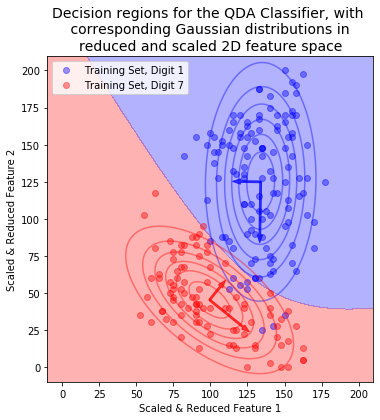

In [14]:
# Transform to 200-by-200 grid.
mu_scaled = transform(mu)
covmat_scaled = transform(transform(covmat))

# Create figure.
plt.figure(figsize=(6,6))

# Visualize the descision regions.
x    = np.linspace(-10, 210, 1000)
X, Y = np.meshgrid(x, x)
pos  = np.dstack((X, Y))
Z1 = multivariate_normal.pdf(pos, mean=mu_scaled[0], cov=covmat_scaled[0])
Z7 = multivariate_normal.pdf(pos, mean=mu_scaled[1], cov=covmat_scaled[1])
Z = (Z1 - Z7) > 0
plt.contourf(X, Y, Z, alpha=0.3, colors=["red", "blue"], levels=1)

# Visualize the two Gaussian distributions.
plt.contour(X,Y,Z1, colors='blue', alpha=0.4)
plt.contour(X,Y,Z7, colors='red', alpha=0.4)

# Eigenvalue/vector decomposition of covariance matricies.
w,v = np.linalg.eig(covmat_scaled)
for i in range(unique_labels.shape[0]):
    for j in range(X_train_red.shape[1]):
        x = mu_scaled[i,0]
        y = mu_scaled[i,1]
        dx = v[i,0,j]*np.sqrt(w[i,j])
        dy = v[i,1,j]*np.sqrt(w[i,j])
        if i == 0:
            c = 'blue'
        else:
            c = 'red'
        plt.arrow(x,y,dx,dy, width=1.2, color=c, alpha=0.7, length_includes_head=True)

# Plot the training set
mask1 = y_train == 1
mask7 = y_train == 7
plt.scatter(transform(X_train_red[mask1,0]), transform(X_train_red[mask1,1]), c="b", alpha=0.4, label='Training Set, Digit 1')
plt.scatter(transform(X_train_red[mask7,0]), transform(X_train_red[mask7,1]), c="r", alpha=0.4, label='Training Set, Digit 7')

# General plot settings
plt.axes().set_aspect('equal')
plt.xlabel('Scaled & Reduced Feature 1')
plt.ylabel('Scaled & Reduced Feature 2')
plt.title('Decision regions for the QDA Classifier, with \n corresponding Gaussian distributions in \nreduced and scaled 2D feature space', fontsize=14)
plt.axes().set_xlim(-10,210)
plt.axes().set_ylim(-10,210)
plt.legend()
plt.savefig('qda.pdf')

### 5.4 - Performance evaluation (3 pts)

In [15]:
# Rename data and labels for better readability.
X = reduce_dim(data_filtered)
y = target_filtered

# K-fold cross-validation.
N_folds = 10
error = np.zeros(N_folds)
kf = model_selection.KFold(n_splits=N_folds, shuffle=True)
i = 0
for train, test in kf.split(X):
    # Split up into training and test folds.
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    
    # Train model and get predictions on test data.
    mu, covmat, p, unique_labels = fit_qda(X_train, y_train)
    y_predictions = predict_qda(mu, covmat, p, X_test, unique_labels)

    # Get error rates.
    error[i] = np.sum(y_predictions != y_test)/y_test.shape[0]
    i += 1

avg_error = np.mean(error)
std_error = np.std(error)
print(f'Mean error rate, {N_folds}-fold cross-valdiation for QDA: {avg_error:.3} ± {std_error:.3}')

Mean error rate, 10-fold cross-valdiation for QDA: 0.0637 ± 0.0374


## 6 - LDA (8 pts)

In [ ]:
def fit_lda(training_features, training_labels):
    """
    Implementation of Linear Discriminant Analysis.
    
    Parameters
    ----------
    training_features: array_type
        Matrix of shape (N,D) with N training instances, each with features in D dimensions. 
    training_labels: array_type
        Vector of shape (N,), with N labels corresponding to training_features.

    Returns
    -------
    mu: array_type
        Maxtrix of shape (C,D) where each row correspond to the class mean in D dimensions, 
        for the C unique classes in training_labels.
    covmat: array_type
        Matrix of shape (D,D) containing the within-class covariance matrix.
    p: array_type
        Vector of shape (C,) containing the C priors for each unique class.
    unique_labels: array_type
        Vector of shape (C,) containing the names of the C unique labels, ordering corresponding
        to the other outputs mu, covmat and p.
    """
    # Find number of unique classes, and their labels.
    unique_labels = np.sort(np.unique(training_labels))
    C = unique_labels.shape[0] 

    # Number of training instances and dimensions in feature space.
    N,D = training_features.shape

    # Pre-allocations.
    mu     = np.zeros((C,D))
    covmat = np.zeros((D,D))
    p      = np.zeros(C)

    # Calculate class means, covariance matricies and prior probabilities.
    for i, label in enumerate(unique_labels):
        mask = training_labels == label
        mu[i] = np.mean(training_features[mask], axis=0)

        #x_mu = training_features[mask]-mu[i] 
        #covmat[i] = np.mean(x_mu[...,None]*x_mu[:,None], axis=0)

    x_mu = training_features-mu[i]


    return mu, covmat, p, unique_labels

In [46]:
unique_labels = np.sort(np.unique(y_train))
for i, label in enumerate(unique_labels):
    mask = y_train == label
    mu[i] = np.mean(X_train[mask], axis=0)
unique_labels[None,:] == y_train
(unique_labels == y_train[:,None])
mu

array([[10.67239264,  9.73128834],
       [ 7.74814815,  3.83580247]])

In [ ]:
def predict_lda(mu, covmat, p, test_features, unique_labels):

    return predicted_labels 

In [16]:
np.cov?

Signature:
np.cov(
    m,
    y=None,
    rowvar=True,
    bias=False,
    ddof=None,
    fweights=None,
    aweights=None,
)
Docstring:
Estimate a covariance matrix, given data and weights.

Covariance indicates the level to which two variables vary together.
If we examine N-dimensional samples, :math:`X = [x_1, x_2, ... x_N]^T`,
then the covariance matrix element :math:`C_{ij}` is the covariance of
:math:`x_i` and :math:`x_j`. The element :math:`C_{ii}` is the variance
of :math:`x_i`.

See the notes for an outline of the algorithm.

Parameters
----------
m : array_like
    A 1-D or 2-D array containing multiple variables and observations.
    Each row of `m` represents a variable, and each column a single
    observation of all those variables. Also see `rowvar` below.
y : array_like, optional
    An additional set of variables and observations. `y` has the same form
    as that of `m`.
rowvar : bool, optional
    If `rowvar` is True (default), then each row represents a
    variable